# Inference runs: GWB parameters recovery and reweighting strategy

In this notebook we show the scripts used for GWB paramters bayesian inference runs. We used `enterprise` functions to write a recovery model and runs a mcmc inference runs. The noise is modelled accordingly to the customised EPTA noise model: for some pulsars their intrinsic noise is modelled as red noise only, for others as DM variations (modelled as a gaussian process), and some are characterised by both processes. The white noise is fixed in the PTA recovery model. The number of Fourier components considered while modelling red noise, DM variations and common process are, respectively, 30, 100 and 9.

To reduce the computational cost of the analysis, we took advantage of the **reweighting tecnique** introduced in [Hourihane et al. 2023](https://arxiv.org/abs/2212.06276). Thus, the mcmc run seraches for a common uncorrelated red noise, and the obtained chain is then reweighted accordingly to the likelihood obtained from an HD correlated model.

In [1]:
from __future__ import print_function, division         
import sys, os, json, shutil

import numpy as np
import matplotlib.pyplot as plt

from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise_extensions import blocks

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

Matplotlib created a temporary config/cache directory at /local/user/serena.valtolina/matplotlib-r9z_zhcz because the default path (/opt/pulsar/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# universe realisation - range: 1001 - 1100
univ_code = '1002'
data_dir = './SMBHB_datasets/univ_' + univ_code + '/'

# definition of the psrs array from .par and .tim files
pulsar_list_dir = './pulsar_list.dat'
pulsar_names = np.loadtxt(pulsar_list_dir,dtype=str)

psrs = []
for name in pulsar_names[:]:
    par_dir = data_dir + 'parfiles/' + name + '.par'
    tim_dir = data_dir + 'tims/' + name + '.tim'
    psr = Pulsar(par_dir, tim_dir)
    psrs.append(psr)

[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.


In [3]:
# noise Maximum Likelihood values dictionary
noise_ML_dir = './ml_params.json'
with open(noise_ML_dir, 'r') as f:
    noise_ML = json.load(f)
    f.close()

In [4]:
# ENTERPRISE recovery model def
#-------------------------------------------------------------------------


# find the maximum time span to set GW frequency sampling
tmin = [p.stoas.min() for p in psrs]
tmax = [p.stoas.max() for p in psrs]
Tspan = np.max(tmax) - np.min(tmin)

# fixing EFAC and EQUAD
efac = parameter.Constant(1.0) 
equad = parameter.Constant(-6)

# white noise
ef = white_signals.MeasurementNoise(efac=efac)
eq = white_signals.TNEquadNoise(log10_tnequad = equad)

# timing model
tm = gp_signals.TimingModel() 

# common red noise signal (uncorrelated)
crn = blocks.common_red_noise_block(psd='powerlaw', prior='log-uniform', Tspan=Tspan, components=9, logmin=-15.5, logmax=-13.5, name='crn')

# model base
model_base = tm + ef + eq + crn


In [5]:
def pulsar_model(psr, model_base):
    
    model = model_base
    
    # red noise
    if psr.name+'_red_noise_gamma' in noise_ML:
        log10_A = parameter.Uniform(-18,-11)
        gamma = parameter.Uniform(0,7)
        pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
        rn = gp_signals.FourierBasisGP(spectrum=pl, components=30)
        model += rn
        
    # DM variations
    if psr.name+'_dm_gamma' in noise_ML:
        log10_A_dm = parameter.Uniform(-18,-8)
        gamma_dm = parameter.Uniform(0, 7)
        pl_dm = utils.powerlaw(log10_A=log10_A_dm, gamma=gamma_dm)
        dm_basis = utils.createfourierdesignmatrix_dm(nmodes=100)
        dm = gp_signals.BasisGP(priorFunction=pl_dm, basisFunction=dm_basis, name='dm')
        model += dm
        
    return model(psr)
        

We have now all the elements to build the PTA object accordingly to the customised noise model:

In [6]:
pta = signal_base.PTA([pulsar_model(psr,model_base) for psr in psrs])

In [7]:
# MCMC RUN
#-----------------------------------------------------------------

xs = {par.name: par.sample() for par in pta.params}
print(pta.params)

# likelihood check
print('\nLikelihood check:\n')
print('ln_likelihood: ',pta.get_lnlikelihood(xs),'\n')
        
# dimension of parameter space
ndim = len(xs)

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

# set up jump groups by red noise groups
groups  = [range(0, ndim)]
groups.extend(map(list, zip(range(0,ndim,2), range(1,ndim,2))))

[J0030+0451_red_noise_gamma:Uniform(pmin=0, pmax=7), J0030+0451_red_noise_log10_A:Uniform(pmin=-18, pmax=-11), J0900-3144_red_noise_gamma:Uniform(pmin=0, pmax=7), J0900-3144_red_noise_log10_A:Uniform(pmin=-18, pmax=-11), J1012+5307_red_noise_gamma:Uniform(pmin=0, pmax=7), J1012+5307_red_noise_log10_A:Uniform(pmin=-18, pmax=-11), J1022+1001_red_noise_gamma:Uniform(pmin=0, pmax=7), J1022+1001_red_noise_log10_A:Uniform(pmin=-18, pmax=-11), J1455-3330_red_noise_gamma:Uniform(pmin=0, pmax=7), J1455-3330_red_noise_log10_A:Uniform(pmin=-18, pmax=-11), J1713+0747_red_noise_gamma:Uniform(pmin=0, pmax=7), J1713+0747_red_noise_log10_A:Uniform(pmin=-18, pmax=-11), J1909-3744_red_noise_gamma:Uniform(pmin=0, pmax=7), J1909-3744_red_noise_log10_A:Uniform(pmin=-18, pmax=-11), J2322+2057_red_noise_gamma:Uniform(pmin=0, pmax=7), J2322+2057_red_noise_log10_A:Uniform(pmin=-18, pmax=-11), crn_gamma:Uniform(pmin=0, pmax=7), crn_log10_A:Uniform(pmin=-15.5, pmax=-13.5)]

Likelihood check:



/enterprise/enterprise/signals/utils.py:885: RuntimeWarning: invalid value encountered in divide
  nmat = Mmat / norm


ln_likelihood:  1116449.3024365036 



In [ ]:
# Sampling for Num steps
#-------------------------------------------------------------------------

Num = int(1e6) 
sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, groups=groups,
                  outDir=data_dir)
x0 = np.hstack([p.sample() for p in pta.params])
sampler.sample(x0, Num, SCAMweight=30, AMweight=15, DEweight=50)

We can now plot the obtained posteriors for a common uncorrelated red noise among our array of pulsars. The nominal values of the amplitude (normalised at the frequency of 1/1yr) for this specific simulated dataset is 2.4e-15.

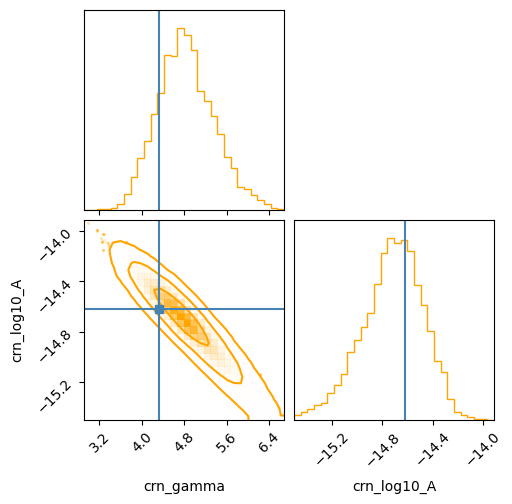

In [8]:
# common uncorrelated red noise parameters posteriors
chain = np.loadtxt(data_dir+'chain_1.txt')
pars = sorted(xs.keys())
burn = int(0.25 * chain.shape[0]) 

# to show the 1, 2 and 3 sigma contours 
exp_lev = np.array([1, 2, 3])
mp_array = 1 - np.exp(-0.5*exp_lev**2)

corner.corner(chain[burn:,-6:-4], 30, labels=pars[-2:], levels=mp_array, color='orange', smooth=True, truths=[4.33, np.log10(2.4*10**(-15))]);
plt.show()

# Reweighting

Now that we have a chain of samples for a common uncorrelated red noise, we can apply the reweighting tecnique to obtain posterior probability distributions for an HD correlated common signal. It is not necessary to reweight the whole chain: usually the first 25% of the chain is neglected beacuse the sampler is far away from convergence. We set with the variable *point* how many samples we will consider while building the weighted GWB posterior.

In [9]:
points = 80000
chain_dir = data_dir + 'chain_1.txt'
output_dir = data_dir + 'weights.txt'

In [10]:
# load chain
chain = np.loadtxt(chain_dir)
chain = chain[-points:,:]
print(len(chain[:,0])) # will be equal to points

80000


We define now a new pta object where, instead of a common uncorrelated red noise, we include an HD correlated one. All the other terms of the recovery model are defined in the same way as before.

In [11]:
# GWB PTA model

orf = utils.hd_orf()
log10_A_gwb = parameter.Uniform(-15.5,-13.5)
gamma_gwb = parameter.Uniform(0,7)
pl_gwb = utils.powerlaw(log10_A=log10_A_gwb, gamma=gamma_gwb)
gw = gp_signals.FourierBasisCommonGP(pl_gwb, orf, components=9, name='gw', Tspan=Tspan)

model_base_hd = tm + ef + eq + gw

In [12]:
pta_hd = signal_base.PTA([pulsar_model(psr,model_base_hd) for psr in psrs])

Sample by sample, we compute all the weights and save them in *weights.txt*. By definition, the average of those weights gives an estimate of the Bayes factor between the HD correlate and the uncorrelated common red noise models. It is also possible to quantify the efficiency of this reweigting tecnique (see [Hourihane et al. 2023](https://arxiv.org/abs/2212.06276) for more details).

In [ ]:
w = []
with open(output_dir, 'w') as f:
    
    f.writelines('logL_crn \t\t\t logL_hd \t\t\t weights \n')

    for i in range (len(chain)):

        xs = chain[i,:-4]

        L_crn = chain[i,-3]
        L_hd = pta_hd.get_lnlikelihood(xs)

        w.append(np.exp(L_hd-L_crn))
        f.writelines(str(L_crn)+' \t\t '+str(L_hd)+' \t\t '+str(np.exp(L_hd-L_crn))+'\n')
                 
    f.close()
                 

In [13]:
w = []
with open(output_dir, 'r') as f:
    lines = f.readlines()
    lines = lines[1:]
    for i in lines:
        w.append(float(i.split()[2]))
    f.close()
    
w = np.array(w)
w_std = np.std(w)
BF = np.mean(w)
n_eff = points/(1+(w_std/BF)**2)
eff = n_eff/points
                 
print('Bayes factor = ', BF,'\t\t reweighting efficency = ',eff)

Bayes factor =  87.01114257330515 		 reweighting efficency =  0.696300217428815


The weights estimation step can take a very long time to be completed. This notebook is meant to be an example of how to implement this algorithm, but it is highly recommended to parallelise this step (this can be easily done by running the script multiple times on different portions of the chain).

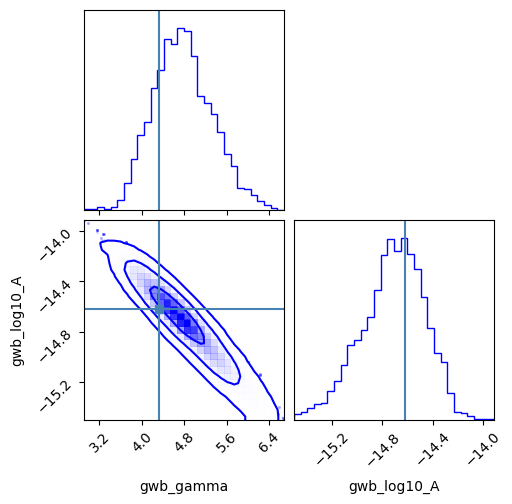

In [14]:
# GWB parameters posterior plot

corner.corner(chain[:,-6:-4], 30, labels=['gwb_gamma', 'gwb_log10_A'], levels=mp_array, weights=w, color='blue', smooth=True, truths=[4.33, np.log10(2.4*10**(-15))]);
plt.show()